In [271]:
%load_ext autoreload
import sys
import os
import time
import argparse
from collections import OrderedDict
from types import SimpleNamespace
import random

import matplotlib.pyplot as plt
import numpy as np
import cairo
from PIL import Image, ImageDraw, ImageFont, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torchsummary import summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
a = np.array([1,2,3])
b = np.array([1,2,3])
np.concatenate((a,b))

array([1, 2, 3, 1, 2, 3])

In [243]:
x = OrderedDict([("a", 1), ("b", 2), ("c", 3)])
y = OrderedDict([("b", 3), ("a", 4)])
# for k,v in y.items():
#     OrderedDict()
# x.update(y)
# x
# OrderedDict([ for k in x])
y2 = y.copy()
y2.update(x)
y2.update(y)
y2

OrderedDict([('b', 3), ('a', 4), ('c', 3)])

In [234]:
while True:
    wh = np.clip(np.random.normal(0.4, 0.2, 2), 0.01, 1)
    cxy = np.random.uniform(0.02, 0.98, 2)
    print(wh)
    # wh = 

    wh = np.clip(wh, 0, 2-2*cxy)
    wh = np.clip(wh, 0, 2*cxy)

    xy1 = cxy - wh/2
    xy2 = cxy + wh/2
    if wh[0] == 0. or wh[1] == 0.:
        print(wh, xy1, xy2, cxy)
        break
        
# wh = np.random.normal(0.4, 0.2, 2)
# cxy = np.random.uniform(0.02, 0.98, 2)

# print(wh)
# np.clip(wh, 0, 2-2*cxy)


[0.77280145 0.15275919]
[0.68607944 0.34929061]
[0.33367762 0.13742428]
[0.67636664 0.28965209]
[0.35571417 0.33968199]
[0.23674153 0.44967075]
[0.12517108 0.46751612]
[0.48793795 0.16697093]
[0.4523569  0.31032648]
[0.52323701 0.86875904]
[0.21828052 0.63515597]
[0.49609808 0.22387679]
[0.52151646 0.74583493]
[0.19213064 0.34329429]
[0.52400717 0.44970294]
[0.32467434 0.77089086]
[0.27002946 0.34391874]
[0.39250045 0.31154128]
[0.46791182 0.14688741]
[0.23619907 0.05961821]
[0.28397841 0.05765177]
[0.4918429  0.18936844]
[0.51407849 0.38421913]
[0.62180137 0.72185123]
[0.40795129 0.58467126]
[0.77849328 0.43662386]
[0.3655603  0.52655665]
[0.25857495 0.44199012]
[0.24347434 0.44793599]
[0.49486068 0.40939755]
[0.37279159 0.56692637]
[0.7553913  0.18033885]
[0.01535679 0.3414184 ]
[0.11072406 0.494041  ]
[0.22460322 0.31238933]
[0.21251883 0.40692939]
[0.21474301 0.28783002]
[0.5311618 0.4833934]
[0.53074402 0.54086152]
[0.47920446 0.11792672]
[0.14540477 0.2526989 ]
[0.58674131 0.7789

[0.01       0.44503191]
[0.23666306 0.35269365]
[0.44069026 0.13213858]
[0.43779989 0.4588275 ]
[0.36470172 0.3481799 ]
[0.34045482 0.54101324]
[0.23465484 0.36710158]
[0.37002617 0.01      ]
[0.07685144 0.94123418]
[0.35192032 0.31199125]
[0.26405443 0.40491177]
[0.76983327 0.03777614]
[0.11910216 0.43997404]
[0.46444478 0.50424185]
[0.2889257  0.76394813]
[0.14244996 0.4036993 ]
[0.66266523 0.31125301]
[0.56964628 0.43276523]
[0.35885042 0.35119582]
[0.59475415 0.59798364]
[0.27315641 0.39843475]
[0.57570531 0.23057302]
[0.43542593 0.75968528]
[0.08590834 0.35280397]
[0.43023131 0.46619747]
[0.45617528 0.6021713 ]
[0.35123213 0.47456564]
[0.155895   0.45854207]
[0.21203614 0.80961617]
[0.27195349 0.72700472]
[0.35134559 0.48936527]
[0.31991661 0.58069147]
[0.3021744  0.24582229]
[0.25670554 0.18750302]
[0.31276546 0.5356743 ]
[0.34758415 0.48144875]
[0.01       0.21075173]
[0.66909538 0.24138285]
[0.31963819 0.41521992]
[0.38525612 0.61547585]
[0.74141975 0.75574532]
[0.69518247 0.36

[0.28757426 0.51674548]
[0.4182755  0.51372367]
[0.19374352 0.01      ]
[0.34658215 0.50265687]
[0.26534833 0.53377463]
[0.48406845 0.26794814]
[0.20258521 0.29920658]
[0.48525275 0.30290241]
[0.58387471 0.24367775]
[0.61485145 0.56807755]
[0.57766917 0.47573085]
[0.56033801 0.34018297]
[0.6930122  0.26851478]
[0.32776478 0.27841989]
[0.57979654 0.38718838]
[0.62194687 0.11381751]
[0.22852249 0.34015474]
[0.41055092 0.55479086]
[0.23557983 0.26136452]
[0.3043153  0.44678983]
[0.30954839 0.13670765]
[0.32194526 0.60522582]
[0.40071412 0.01      ]
[0.35881042 0.49729153]
[0.46440883 0.39720404]
[0.02151816 0.53128333]
[0.28309965 0.32070971]
[0.26661231 0.25930177]
[0.46384063 0.64432669]
[0.36182643 0.27527277]
[0.01       0.79783116]
[0.17363278 0.54103172]
[0.54090984 0.17465996]
[0.40946097 0.48553411]
[0.0949112  0.46043014]
[0.42378481 0.11169334]
[0.4576845  0.27505257]
[0.38430307 0.25648676]
[0.47807852 0.585155  ]
[0.82236108 0.72954969]
[0.37197612 0.36507549]
[0.20610655 0.80

[0.54336812 0.52232513]
[0.4001963  0.29148779]
[0.32869322 0.51654633]
[0.49403663 0.29862155]
[0.66496388 0.58527537]
[0.26395842 0.44702574]
[0.26884141 0.69465186]
[0.32411752 0.22721562]
[0.79434669 0.42139956]
[0.41166684 0.65249939]
[0.63201526 0.64799908]
[0.39792757 0.22947034]
[0.17917627 0.01      ]
[0.30804755 0.63650991]
[0.01       0.22044232]
[0.45308267 0.67471271]
[0.01       0.12742185]
[0.78488531 0.51541802]
[0.11692815 0.20570001]
[0.1224605  0.13263825]
[0.46037728 0.22379165]
[0.10071472 0.74409476]
[0.29246752 0.41029223]
[0.59461521 0.55786006]
[0.32796844 0.33524675]
[0.2039615  0.30528476]
[0.42366805 0.61228777]
[0.57862438 0.54057002]
[0.22790614 0.52268835]
[0.77071045 0.37861235]
[0.16832223 0.4554517 ]
[0.01     0.419274]
[0.23928295 0.07941911]
[0.23216693 0.54311435]
[0.32237016 0.35258923]
[0.3964528  0.53560998]
[0.5597599  0.15636943]
[0.32204289 0.21078551]
[0.39751205 0.28689255]
[0.48202938 0.50012177]
[0.15117659 0.20082434]
[0.12000234 0.01    

[0.54578978 0.25913014]
[0.46274318 0.40783127]
[0.38360947 0.61410419]
[0.58612366 0.44237395]
[0.50793567 0.41911272]
[0.32897544 0.67908718]
[0.08517833 0.18696143]
[0.49621494 0.50924057]
[0.28923171 0.01      ]
[0.35047379 0.24686943]
[0.49699348 0.49691531]
[0.51604549 0.48717144]
[0.68719101 0.38600061]
[0.44912805 0.25032124]
[0.13605339 0.2776897 ]
[0.2519043  0.31074868]
[0.44209011 0.67341319]
[0.79755666 0.23179861]
[0.53906911 0.49686639]
[0.27783903 0.72844903]
[0.51704967 0.36951934]
[0.25545187 0.45125946]
[0.42757212 0.20250845]
[0.85568961 0.33006925]
[0.06019878 0.50055087]
[0.63300876 0.3100197 ]
[0.16778441 0.54019465]
[0.12982546 0.78785805]
[0.60592273 0.19391118]
[0.22834    0.33987978]
[0.617138   0.23923617]
[0.58030832 0.20640264]
[0.56475959 0.65812984]
[0.24702354 0.42648943]
[0.40356628 0.67141433]
[0.1951743  0.53696337]
[0.01       0.19910255]
[0.2683555  0.64186122]
[0.56148283 0.45170743]
[0.41656914 0.58222145]
[0.01       0.70635159]
[0.27928884 0.47

[0.41862921 0.492582  ]
[0.27145059 0.3279092 ]
[0.38367658 0.17463128]
[0.33224986 0.86522768]
[0.24482363 0.59595138]
[0.13856276 0.16810983]
[0.44710366 0.2273164 ]
[0.22887976 0.57074108]
[0.17283569 0.58502178]
[0.88628279 0.44986879]
[0.40665585 0.51018709]
[0.50323964 0.81790339]
[0.59788372 0.36977908]
[0.5128859 0.0833733]
[0.42022012 0.40208011]
[0.40838024 0.17258046]
[0.39514652 0.37097407]
[0.39041043 0.54549193]
[0.2328529  0.34171717]
[0.28943697 0.39459005]
[0.41131415 0.08554936]
[0.52481432 0.45878942]
[0.01       0.31598685]
[0.13850261 0.51475331]
[0.27522925 0.57327182]
[0.47550405 0.22592728]
[0.41459404 0.66870258]
[0.67878721 0.47653537]
[0.26669064 0.47776592]
[0.32111852 0.57267803]
[0.77228855 0.75833104]
[0.3710087 0.293452 ]
[0.66084518 0.36831869]
[0.55154384 0.56646523]
[0.46774663 0.60652869]
[0.70912116 0.5693951 ]
[0.66101339 0.33522828]
[0.21406528 0.79437205]
[0.56316994 0.47803637]
[0.0948052  0.41954385]
[0.4134372  0.31333407]
[0.63114187 0.064464

[0.50316344 0.01      ]
[0.41969311 0.64939595]
[0.65696971 0.42754852]
[0.3438256  0.10122216]
[0.3181582  0.24364917]
[0.69525502 0.73414684]
[0.25635803 0.62640023]
[0.23944099 0.23849598]
[0.32830148 0.31825367]
[0.5255121  0.38630536]
[0.26510433 0.50923069]
[0.47022582 0.2574498 ]
[0.33170487 0.69734914]
[0.71188008 0.44448561]
[0.06892776 0.40772054]
[0.35838511 0.63849603]
[0.01      0.3363406]
[0.22336372 0.20471919]
[0.32107734 0.75161753]
[0.27562756 0.37729464]
[0.47092659 0.16565646]
[0.82016882 0.24741713]
[0.22886292 0.587263  ]
[0.70984769 0.63616599]
[0.31494253 0.53529072]
[0.42173003 0.53471508]
[0.45623827 0.51674379]
[0.74004672 0.37792267]
[0.10624632 0.53816635]
[0.62570448 0.01815621]
[0.46402984 0.59700158]
[0.80533771 0.37748329]
[0.58851368 0.45561043]
[0.24844073 0.42401567]
[0.30617488 0.33470901]
[0.15762079 0.2012342 ]
[0.82965185 0.38550398]
[0.55063437 0.35000064]
[0.20334729 0.40569124]
[0.67102262 0.07201805]
[0.41005933 0.23710817]
[0.74699981 0.0262

[0.27348011 0.03131992]
[0.61812223 0.35103634]
[0.47880988 0.28891549]
[0.78824849 0.24101774]
[0.26413925 0.345673  ]
[0.29854757 0.26678883]
[0.54310329 0.77351258]
[0.55802775 0.42351263]
[0.22392191 0.73635638]
[0.58821964 0.01      ]
[0.54133421 0.3034977 ]
[0.16877026 0.39560619]
[0.18092198 0.5720669 ]
[0.61070959 0.50768283]
[0.24812916 0.86163351]
[0.19870007 0.18028797]
[0.01      0.0468907]
[0.11155629 0.44836696]
[0.16022802 0.19120721]
[0.23197469 0.59996621]
[0.75976457 0.24380873]
[0.31972011 0.23763215]
[0.16494803 0.08168967]
[0.45460013 0.41513651]
[0.17521012 0.26795123]
[0.27780486 0.58341467]
[0.38531622 0.70891733]
[0.51165502 0.90606683]
[0.69407711 0.60873803]
[0.32805535 0.19379126]
[0.86312891 0.37277062]
[0.53494371 0.61168095]
[0.39838758 0.17137569]
[0.38807484 0.77332227]
[0.19117036 0.43348276]
[0.43128511 0.47404095]
[0.51759973 0.56914015]
[0.56236102 0.45315822]
[0.58575598 0.32988077]
[0.16897007 0.42234624]
[0.30804201 0.25216969]
[0.29992946 0.4072

[0.37776174 0.43616423]
[0.56732418 0.27429217]
[0.35825061 0.39156822]
[0.21917891 0.23569141]
[0.41476604 0.33853382]
[0.33616009 0.49089064]
[0.20043456 0.21667272]
[0.24449565 0.47894804]
[0.75141793 0.56628228]
[0.54950392 0.57933651]
[0.47481121 0.37379118]
[0.23498896 0.1485338 ]
[0.07137276 0.58122238]
[0.06090153 0.36311657]
[0.29092416 0.1977053 ]
[0.64095593 0.8035802 ]
[0.52152848 0.1213264 ]
[0.91501133 0.76435469]
[0.29151854 0.7163564 ]
[0.51906332 0.43199818]
[0.01910167 0.3095353 ]
[0.62946505 0.25038223]
[0.69800913 0.35191784]
[0.68554213 0.97113004]
[0.22562055 0.48021165]
[0.47723461 0.34074366]
[0.26648737 0.35134371]
[0.04772029 0.44046544]
[0.28252897 0.38728396]
[0.56951076 0.26332473]
[0.02455608 0.44025423]
[0.46492547 0.67813104]
[0.48390679 0.25077513]
[0.64295379 0.44365137]
[0.37208143 0.61988481]
[0.41284216 0.17183972]
[0.41044602 0.27907111]
[0.64354262 0.44208021]
[0.47171003 0.28587153]
[0.57348055 0.14215246]
[0.62972777 0.4545082 ]
[0.64916633 0.67

[0.50046802 0.47373601]
[0.09555667 0.01      ]
[0.28035621 0.44792439]
[0.27361894 0.46082207]
[0.72588616 0.20506395]
[0.68599395 0.36832415]
[0.22677999 0.28515582]
[0.33649539 0.06398998]
[0.22827273 0.3404292 ]
[0.42223377 0.48638597]
[0.43301678 0.21730142]
[0.70427277 0.51292487]
[0.4209129  0.10865362]
[0.62115711 0.50091398]
[0.54675847 0.50021208]
[0.1667452  0.57019137]
[0.05089236 0.70275688]
[0.54137107 0.31121613]
[0.65783796 0.17538962]
[0.04825544 0.32974351]
[0.39418175 0.31458427]
[0.01       0.31488453]
[0.66952259 0.65794797]
[0.66605468 0.67844748]
[0.54470079 0.5168451 ]
[0.29047352 0.22039644]
[0.49973392 0.39868983]
[0.23248205 0.33478772]
[0.38458021 0.87852603]
[0.43449229 0.76958447]
[0.37038874 0.49848673]
[0.15008896 0.58925765]
[0.0995664  0.59586905]
[0.01       0.35852439]
[0.19879225 0.20970998]
[0.66587165 0.41058864]
[0.02510573 0.80099135]
[0.202243  0.1318769]
[0.64840742 0.12271439]
[0.76737805 0.28635345]
[0.35631617 0.01      ]
[0.97865866 0.2978

[0.22993065 0.05895099]
[0.45006417 0.32475182]
[0.25060518 0.56400811]
[0.34251823 0.07543701]
[0.35777377 0.53638109]
[0.54072846 0.29348364]
[0.3212619  0.35272574]
[0.28704894 0.33449205]
[0.56394777 0.49906461]
[0.46726662 0.42861974]
[0.63202873 0.36607323]
[0.65000482 0.01      ]
[0.01       0.18068691]
[0.17808244 0.33120486]
[0.4329596  0.11500749]
[0.44530044 0.28182503]
[0.1820196  0.35082396]
[0.27229235 0.58509447]
[0.33419654 0.36381038]
[0.57900733 0.25234502]
[0.29546896 0.23296064]
[0.24130927 0.02589936]
[0.29021807 0.60789407]
[0.60210699 0.26640108]
[0.41850926 0.3014997 ]
[0.31681755 0.31497849]
[0.44947299 0.35144008]
[0.50440333 0.27584358]
[0.58525374 0.40779545]
[0.46986531 0.69845949]
[0.49564939 0.4043905 ]
[0.60417929 0.22287111]
[0.43482977 0.36484374]
[0.49723353 0.57711104]
[0.59732194 0.6865827 ]
[0.43070202 0.32105288]
[0.25515644 0.32772956]
[0.63976044 0.51073804]
[0.66507281 0.34411433]
[0.33972625 0.38931813]
[0.71400772 0.09849306]
[0.99162269 0.58

[0.47659314 0.73215221]
[0.55539219 0.51134823]
[0.48923615 0.1524003 ]
[0.34850336 0.53820407]
[0.70837003 0.46667615]
[0.53983169 0.8347255 ]
[0.65728974 0.62679996]
[0.16888071 0.21074023]
[0.26880063 0.11215093]
[0.14251775 0.51094618]
[0.30001531 0.5139326 ]
[0.46526919 0.4761081 ]
[0.41457495 0.50752483]
[0.72023006 0.55437367]
[0.21256526 0.67999097]
[0.39309729 0.21869284]
[0.71936797 0.51935701]
[0.4406628  0.22806392]
[0.72211801 0.54178128]
[0.62269082 0.36842202]
[0.50178729 0.57303097]
[0.22910315 0.16047878]
[0.46336778 0.31676554]
[0.33971933 0.15568383]
[0.47325798 0.18592773]
[0.40313304 0.87692977]
[0.39078802 0.38524154]
[0.45013121 0.25893657]
[0.35313085 0.40247548]
[0.5742033  0.54385496]
[0.21025384 0.30977662]
[0.90976609 0.26367477]
[0.12539887 0.50765044]
[0.41587558 0.40419677]
[0.21480799 0.23932887]
[0.22117488 0.44321469]
[0.52404886 0.14006616]
[0.47610891 0.4153634 ]
[0.339187   0.56141372]
[0.61482336 0.51581084]
[0.53163736 0.37327306]
[0.22664534 0.37

[0.53740411 0.44427391]
[0.51943267 0.5366871 ]
[0.1717313  0.16797643]
[0.01       0.63298047]
[0.17878503 0.49911415]
[0.21830849 0.25479694]
[0.23329158 0.01      ]
[0.21924627 0.47035218]
[0.57859256 0.38914189]
[0.64855594 0.46455956]
[0.52200828 0.20690534]
[0.37016906 0.79211089]
[0.59777185 0.01496115]
[0.44610938 0.72663695]
[0.25700079 0.23384506]
[0.27962028 0.25322694]
[0.75852386 0.58468925]
[0.12290467 0.20591271]
[0.3024316  0.26164856]
[0.31320153 0.21238952]
[0.6709958 1.       ]
[0.60367169 0.60025827]
[0.46567209 0.18173016]
[0.29115573 0.48947238]
[0.30002459 0.4913869 ]
[0.24131104 0.63426062]
[0.21700152 0.29590917]
[0.52594817 0.32077459]
[0.99069799 0.82856602]
[0.20232409 0.41929181]
[0.55184584 0.19358756]
[0.59028937 0.32427191]
[0.09609782 0.3725953 ]
[0.48010732 0.30241202]
[0.20489227 0.33471496]
[0.66308867 0.46410507]
[0.87594058 0.6811504 ]
[0.40944706 0.55909896]
[0.29153223 0.24847372]
[0.42392555 0.36357787]
[0.36875433 0.36424342]
[0.50545985 0.4151

[0.19068943 0.32323947]
[0.17461609 0.56002585]
[0.61200986 0.60288578]
[0.1544023 0.1838923]
[0.66245512 0.05538172]
[0.58418227 0.91553832]
[0.40652317 0.35760149]
[0.36102883 0.46608698]
[0.20024207 0.37308667]
[0.54897191 0.49597476]
[0.07820738 0.26341793]
[0.61905847 0.37340214]
[0.86047562 0.18923959]
[0.01      0.2900206]
[0.36242138 0.57876475]
[0.32454056 0.5498123 ]
[0.3156413  0.37451252]
[0.52958131 0.32269654]
[0.04329439 0.01      ]
[0.37082069 0.95873851]
[0.41662278 0.8242101 ]
[0.41543805 0.41143052]
[0.26898736 0.45459856]
[0.53384535 0.01      ]
[0.6572094  0.41350735]
[0.48664869 0.6930387 ]
[0.37595095 0.85146658]
[0.12204657 0.35887763]
[0.57122891 0.01      ]
[0.33370233 0.47589429]
[0.42869361 0.5006419 ]
[0.28808395 0.30424646]
[0.51486635 0.3560246 ]
[0.29655803 0.43673812]
[0.52905094 0.57965635]
[0.34898206 0.53405821]
[0.55234506 0.29799938]
[0.41048256 0.10196561]
[0.69117382 0.40714763]
[0.53838664 0.79651772]
[0.55744684 0.36664563]
[0.50072653 0.287744

[0.46419329 0.50888827]
[0.21488113 0.52168438]
[0.61249854 0.36753559]
[0.36328939 0.42025552]
[0.26930184 0.5397862 ]
[0.21968501 0.19220507]
[0.42962374 0.51270608]
[0.43141438 0.56098312]
[0.27652477 0.24470959]
[0.06662256 0.36636674]
[0.29582437 0.34459101]
[0.45082988 0.62027842]
[0.30055942 0.44717238]
[0.37075513 0.48494018]
[0.37137385 0.56162274]
[0.32007047 0.94218617]
[0.31402705 0.45979906]
[0.41950482 0.65141401]
[0.24878857 0.46815264]
[0.26574441 0.13481502]
[0.39981865 0.14640113]
[0.4661662  0.40966615]
[0.65062549 0.16792272]
[0.34259507 0.93018359]
[0.20130697 0.07785629]
[0.65813523 0.36549565]
[0.65222518 0.25514241]
[0.5871063  0.60999856]
[0.38812595 0.34913486]
[0.6366858  0.68751189]
[0.55632263 0.4492159 ]
[0.79445636 0.61770445]
[0.30000443 0.21445839]
[0.45242389 0.41108621]
[0.45918899 0.52278653]
[0.48778051 0.01      ]
[0.54185999 0.67527574]
[0.52689986 0.36280275]
[0.20436339 0.58379381]
[0.06616921 0.17063688]
[0.33237749 0.30522425]
[0.47252837 0.41

[0.47501198 0.20111473]
[0.48760426 0.31650379]
[0.20651178 0.83170025]
[0.61437637 0.36493789]
[0.60642011 0.29878522]
[0.51903193 0.50252946]
[0.1586716  0.36459082]
[0.43277474 0.43718003]
[0.64721912 0.2237789 ]
[0.41449152 0.53568157]
[0.62952477 0.52282011]
[0.0830491 0.2607674]
[0.65242749 0.33827774]
[0.41793637 0.50152796]
[0.45982364 0.46244073]
[0.23692247 0.16436616]
[0.40817156 0.58367999]
[0.66191985 0.04631092]
[0.30462497 0.41885897]
[0.64216772 0.4513783 ]
[0.64761354 0.01      ]
[0.52932555 0.29781973]
[0.45257182 0.46202466]
[0.42437026 0.18257343]
[0.10339612 0.49959957]
[0.78816955 0.7265924 ]
[0.33717357 0.39492755]
[0.05974422 0.50417178]
[0.17601555 0.47169132]
[0.50404806 0.36684956]
[0.47666574 0.40586406]
[0.22734502 0.31234455]
[0.18095573 0.21313369]
[0.50550069 0.01      ]
[0.42708404 0.73862514]
[0.35483899 0.54713495]
[0.47072271 0.41249549]
[0.69953223 0.27751451]
[0.40183907 0.01      ]
[0.11782491 0.35127611]
[0.2475372  0.29858939]
[0.46615047 0.4239

[0.01       0.45038191]
[0.59541643 0.10081601]
[0.26768679 0.61472569]
[0.20022812 0.73857571]
[0.3976516  0.64131945]
[0.43358581 0.12150598]
[0.01       0.69026877]
[0.39222479 0.01      ]
[0.61685244 0.60695661]
[0.38706093 0.27689371]
[0.78516357 0.0544007 ]
[0.50237307 0.25616273]
[0.15238441 0.3275699 ]
[0.53834424 0.64033989]
[0.45319982 0.57337782]
[0.28798285 0.57741341]
[0.17329048 0.43666869]
[0.33644736 0.57566026]
[0.66701625 0.93015977]
[0.16970675 0.42024871]
[0.32871228 0.49182995]
[0.11518188 0.69594375]
[0.57358379 0.28095392]
[0.43546942 0.84904136]
[0.71002419 0.1263438 ]
[0.48751911 0.42985408]
[0.29861603 0.12552858]
[0.06557323 0.37574248]
[0.64440306 0.68418911]
[0.2179825  0.09082678]
[0.54002006 0.39494841]
[0.30927632 0.36991797]
[0.69803371 0.38854679]
[0.1199947  0.25500556]
[0.19975249 0.24217385]
[0.58690046 0.35273472]
[0.45146047 0.17020491]
[0.45236907 0.37332649]
[0.22957351 0.29130574]
[0.41871963 0.62555066]
[0.45695161 0.85817945]
[0.17749014 0.20

[0.16704947 0.7186273 ]
[0.28236024 0.49049265]
[0.30164681 0.48292967]
[0.39926227 0.22576195]
[0.30731405 0.33865581]
[0.01      0.5201866]
[0.38012489 0.29938425]
[0.06383066 0.26266702]
[0.46819776 0.49775893]
[0.59797458 0.64121976]
[0.39473488 0.43287334]
[0.17184204 0.44575363]
[0.77759051 0.50352077]
[0.53180029 0.26686703]
[0.43066707 0.0554511 ]
[0.36706256 0.36548554]
[0.49127028 0.50928361]
[0.55151079 0.34078667]
[0.73655141 0.45591807]
[0.51644864 0.58522352]
[0.41817486 0.23048347]
[0.30343374 0.34889972]
[0.22100361 0.34563118]
[0.50279422 0.23962774]
[0.01       0.57348734]
[0.36418304 0.35641538]
[0.32074815 0.36033611]
[0.44109007 0.29292342]
[0.04669349 0.38833783]
[0.36032838 0.20232012]
[0.61690349 0.06661037]
[0.10213796 0.38745776]
[0.29229614 0.62925992]
[0.42285132 0.64449167]
[0.08443281 0.30411905]
[0.46046205 0.29532226]
[0.65595781 0.1205478 ]
[0.58447193 0.46531671]
[0.01       0.62694675]
[0.45663292 0.02424899]
[0.45544235 0.76491345]
[0.67339935 0.01  

[0.40717585 0.37377627]
[0.42310837 0.43678176]
[0.04135575 0.41538607]
[0.21371459 0.43440096]
[0.47193035 0.79719788]
[0.427597   0.55434221]
[0.3687937  0.40358573]
[0.30955477 0.48959843]
[0.68251687 0.12885803]
[0.6026859  0.14991676]
[0.17924241 0.22262108]
[0.55425749 0.20348972]
[0.44214223 0.92296825]
[0.19461029 0.37107592]
[0.24284214 0.48749138]
[0.20761294 0.46051941]
[0.4519535  0.46287538]
[0.09564693 0.3773906 ]
[0.117964   0.59964205]
[0.61130859 0.50440265]
[0.18883589 0.46148248]
[0.21517852 0.45574428]
[0.41153349 0.01      ]
[0.38988204 0.61074464]
[0.48670969 0.61339163]
[0.50216498 0.24575311]
[0.41497943 0.60244074]
[0.61692546 0.74211476]
[0.25450038 0.22140803]
[0.58011739 0.62145014]
[0.30771082 0.32394887]
[0.29793244 0.48483659]
[0.19901279 0.25227653]
[0.62980242 0.29653747]
[0.54580718 0.59816067]
[0.31340093 0.01      ]
[0.79024181 0.48490528]
[0.56249219 0.99183082]
[0.42623794 0.43832185]
[0.16814343 0.45666205]
[0.49792441 0.01      ]
[0.41100771 0.01

[0.53911577 0.2773393 ]
[0.46912498 0.47890244]
[0.20011757 0.40158522]
[0.5668443  0.08770096]
[0.29728138 0.41134951]
[0.5720134  0.31539269]
[0.33464256 0.53987606]
[0.37379493 0.7219159 ]
[0.28327337 0.68061212]
[0.56601899 0.51614206]
[0.78842236 0.28974938]
[0.31740627 0.14627934]
[0.34938245 0.37052857]
[0.63676946 0.51773063]
[0.4680279 0.5176406]
[0.60611557 0.23727677]
[0.64846809 0.57482043]
[0.71656382 0.28028164]
[0.24461077 0.43956525]
[0.07433557 0.8431539 ]
[0.31875642 0.54665237]
[0.29921221 0.09461798]
[0.47639651 0.43903876]
[0.17528835 0.71021336]
[0.597007   0.42692263]
[0.58482242 0.54623262]
[0.26374843 0.25676387]
[0.64010191 0.24573738]
[0.86982193 0.1642529 ]
[0.18339704 0.62077323]
[0.05850845 0.49547523]
[0.6234511  0.56833178]
[0.61973142 0.29865319]
[0.68810043 0.40038686]
[0.52913636 0.20331178]
[0.3894176  0.57363743]
[0.51277983 0.5448974 ]
[0.27470234 0.60604273]
[0.53843832 0.69036901]
[0.96930613 0.70659338]
[0.4551826  0.18201776]
[0.94038397 0.3453

KeyboardInterrupt: 

In [341]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src

from data import ParamDataset
from generator.blocks import CLASSES

ds = ParamDataset("/workspace/CRAFT-pytorch/my-dataset/train.json", cats=CLASSES)
# _, _, cat, pre_cat, p, _ = ds[1]
# _, _, _, _, _, cats = ds[1]
# cats
dl = torch.utils.data.DataLoader(ds, batch_size=2, shuffle=True)
for x in dl:
    print(x)
    break



/workspace/CRAFT-pytorch/my-src
[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
    

In [12]:
a = (1,2,3)
a.index(3)

2

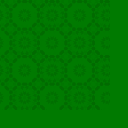

In [17]:
imsize = 128
im = Image.new("RGBA", (imsize, imsize))
draw = ImageDraw.Draw(im)
draw.rectangle((0, 0, 128, 128), fill=(0, 122, 0, 255))

p = Image.open("/workspace/transparent-textures/patterns/arab-tile.png")
p = p.convert("RGBA")
p.thumbnail((128, 128))

# print(np.array(p))

im.alpha_composite(p)
im



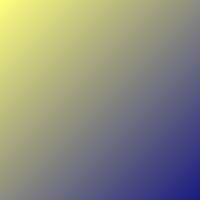

In [270]:
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
cr = cairo.Context(surface)
cr.scale(200, 200)
pat = cairo.LinearGradient(0, 0, 1, 1)
pat.add_color_stop_rgba(0, 0.5, 1, 1, 1)
pat.add_color_stop_rgba(1, 0.5, 0.1, 0.1, 1)
cr.rectangle(0, 0, 1, 1)
cr.set_source(pat)
cr.fill()
data = np.ndarray(
    shape=(200, 200, 4), dtype=np.uint8, buffer=surface.get_data()
)
im = Image.fromarray(data)
im

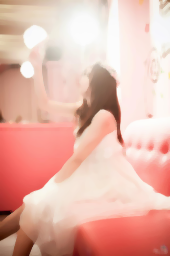

In [33]:
im = Image.open("/workspace/CoordConv-pytorch/data/facebook/60122_528371913855789_1929735771_n.jpg")
im.thumbnail((256, 256))
im.filter(ImageFilter.MedianFilter(5))

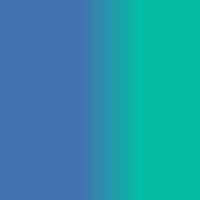

In [50]:
import cairo

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
cr = cairo.Context(surface)
cr.scale(200, 200)

# pat = cairo.LinearGradient(0, 0, 0, 1)
pat = cairo.LinearGradient(0, 0, 1, 0)

for rgb in np.random.uniform(0, 1, (2, 4)):
    pat.add_color_stop_rgba(*rgb, 1)

# pat.add_color_stop_rgba(1, 0, 0, 0, 1)
# pat.add_color_stop_rgba(0, 1, 1, 1, 1)
cr.rectangle(0, 0, 1, 1)
cr.set_source(pat)
cr.fill()

data = np.ndarray(
    shape=(200, 200, 4), dtype=np.uint8, buffer=surface.get_data()
)
im = Image.fromarray(data)
im

/workspace/CRAFT-pytorch/my-src/generator
[<PIL.Image.Image image mode=L size=256x256 at 0x7F863942FAC8>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863941E828>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863942F9B0>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863942F9E8>, <PIL.Image.Image image mode=L size=256x256 at 0x7F863942FB00>] [2, 1, 3, 3, 3] []


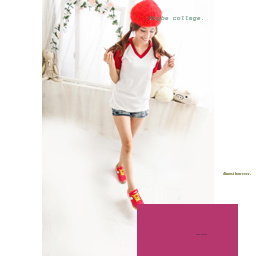

In [53]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src/generator

# from generator.mask import create_mask
import random
from main import Sampler
import blocks as bk

opt = SimpleNamespace()
opt.imsize = 256

# p = {"_a": np.array([1.0]), "_wh": np.array([1.0, 1.0]), "_cxy": np.array([0.5, 0.5]), "repeat": True}
p = {"_a": np.array([1.0]), "_wh": np.array([1.0, 1.0]), "_cxy": np.array([0.5, 0.5])}
bg = bk.Choice([bk.Rectangle(p), bk.Photo("/workspace/CoordConv-pytorch/data/facebook", p)])
text = bk.Choice([
    bk.Line(),
    bk.Group([bk.Line(), bk.Line()]),
    bk.Group([bk.Line(), bk.Line(), bk.Line()]),
])
dec = bk.Rectangle()

# g = bk.Group([bk.Line()])
# cm = bk.CropMask(bk.Line(), bk.Photo("/workspace/CoordConv-pytorch/data/facebook"))
# cm = bk.CropMask(bk.Line(), bk.Rectangle())

texture = bk.Photo("/workspace/transparent-textures/patterns", p)
cm = bk.CropMask(texture, bk.Rectangle({"_a": np.array([1])}))
# cm2 = bk.CropMask(bk.Line(), cm)


s = Sampler([bg, dec,text], opt)
im, (mask_t, cat_t, params_t) = s.sample()

print(mask_t, cat_t, params_t)
im
# mask_t[0]

[[[ 0  0  0  0]
  [ 0  0  0 26]
  [ 8  0  0 33]
  ...
  [ 8  0  0 33]
  [ 8  0  0 32]
  [ 0  0  0  5]]

 [[ 0  0  0 11]
  [ 8  0  0 33]
  [ 8  0  0 33]
  ...
  [ 8  0  0 33]
  [ 8  0  0 33]
  [ 8  0  0 33]]

 [[ 8  0  0  0]
  [ 0  0  0 27]
  [ 8  0  0 33]
  ...
  [ 8  0  0 33]
  [ 7  0  0 34]
  [ 0  0  0 14]]

 ...

 [[ 0  0  0  2]
  [ 0  0  0  0]
  [ 0  0  0  0]
  ...
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  3]]

 [[ 0  0  0  3]
  [ 0  0  0  0]
  [ 0  0  0  0]
  ...
  [ 0  0  0  0]
  [ 0  0  0  3]
  [ 0  0  0  2]]

 [[ 0  0  0  3]
  [ 0  0  0  0]
  [ 0  0  0  8]
  ...
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  3]]]


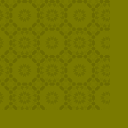

In [181]:
imsize = 128
im = Image.new("RGBA", (imsize, imsize))

# mask = Image.new("RGBA", (imsize, imsize))
draw = ImageDraw.Draw(im)
draw.rectangle((0, 0, imsize, imsize), fill=(122, 122, 0, 255))

p = Image.open("/workspace/transparent-textures/patterns/arab-tile.png")
p = p.convert("RGBA")
p.thumbnail((128, 128))

# print(np.array(p))

im.alpha_composite(p)

# Image.composite(p, im, mask)
# np.array(x)
im

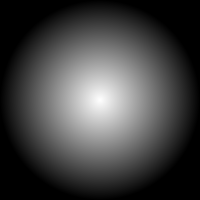

In [226]:
from math import pi

from io import BytesIO
import cairo
import IPython.display

pattern = cairo.MeshPattern()
pattern.begin_patch()
pattern.move_to(0, 0)
pattern.curve_to(30/200, -30/200, 60/200, 30/200, 100/200, 0)
pattern.curve_to(60/200, 30/200, 130/200, 60/200, 100/200, 100/200)
pattern.curve_to(60/200, 70/200, 30/200, 130/200, 0, 100/200)
pattern.curve_to(30/200, 70/200, -30/200, 30/200, 0, 0)
pattern.set_corner_color_rgb(0, 1, 0, 0)
pattern.set_corner_color_rgb(1, 0, 1, 0)
pattern.set_corner_color_rgb(2, 0, 0, 1)
pattern.set_corner_color_rgb(3, 1, 1, 0)
pattern.end_patch()

# svgio = BytesIO()
# with cairo.SVGSurface(svgio, 200, 200) as surface:

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
cr = cairo.Context(surface)
cr.scale(200, 200)

# pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
# for p in np.random.uniform(0, 1, (5, 4)):
#     pat.add_color_stop_rgba(*tuple(p), 1)

pat = cairo.RadialGradient(0.5, 0.5, 0., 0.5, 0.5, 0.5)
# pat.add_color_stop_rgba(0, 0.4, 0.8, 0, 1)
# pat.add_color_stop_rgba(1, 0.4, 0.9, 0.5, 1)
pat.add_color_stop_rgba(0, 1, 1, 1, 1)
pat.add_color_stop_rgba(1, 0, 0, 0, 1)


cr.set_source(pat)
cr.rectangle(0, 0, 1, 1)
cr.fill()
    
#     pat.add_color_stop_rgba(0, 1, 1, 1, 1)
#     pat.add_color_stop_rgba(1, 0, 0, 0, 1)
# cr.set_line_width(0.04)
# pat = cairo.RadialGradient(0.45, 0.4, 0.1,
#                                0.4, 0.4, 0.5)
# pat.add_color_stop_rgba(0, 1, 1, 1, 1)
# pat.add_color_stop_rgba(1, 0, 0, 0, 1)
# cr.set_source(pat)
# cr.arc(0.5, 0.5, 0.3, 0, 1 * pi)
# cr.fill()


# IPython.display.SVG(data=svgio.getvalue())


# width, height = 255, 255
# surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
data = np.ndarray(shape=(200, 200, 4),
                     dtype=np.uint8,
                     buffer=surface.get_data())
# data.shape

im = Image.fromarray(data)
im
# data



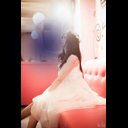

In [2]:
imsize = 128
im = Image.new("RGB", (imsize, imsize))
# font = ImageFont.truetype('font.ttf', 200, encoding='unic')

# draw = ImageDraw.Draw(im)
# draw.rectangle((0, 0, imsize, imsize), fill=(22, 128, 128))
p = Image.open("/workspace/CoordConv-pytorch/data/facebook/60122_528371913855789_1929735771_n.jpg")
p.thumbnail((128, 128))
cx, cy = 64, 64
im.paste(p, (int(cx-p.width/2), int(cy-p.height/2)))
im = im.convert("RGBA")

im2 = Image.new("RGB", (imsize, imsize))
draw = ImageDraw.Draw(im2)
draw.rectangle((0, 0, imsize, imsize), fill=(10, 10, 80))
mask = Image.new("L", (imsize, imsize))
draw = ImageDraw.Draw(mask)
draw.rectangle((30, 30, 60, 60), fill=255)
mask = mask.filter(ImageFilter.GaussianBlur(10))
im2.putalpha(mask)

im.alpha_composite(im2)
im
# im2.mode
# im.mode
# Image.alpha_composite(im, im2)

In [5]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src
import glob
# from data import MyDataset
from algo.kmeans import lloyd
from model.vgg import VGGFeatures

opt = SimpleNamespace()
opt.imsize = 64
opt.n_samples = 100
opt.n_layers = 3
opt.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opt.root = "../tmp"

model = VGGFeatures().to(opt.device)
model.eval()
trans = transforms.Compose(
    [
        transforms.Resize((opt.imsize, opt.imsize)),
        transforms.ToTensor(),
    ]
)

feats = []
for f in glob.glob(opt.root + "/*"):
    x = trans(Image.open(f))
    x = x.unsqueeze(0)
    x = model(x)
    print(x.shape)
    feats.append(x)
feats = torch.cat(feats, dim=0).detach().numpy()
feats.shape

# idx, ctr = lloyd(feats, 2, opt.device)


# d = MyDataset(opt)
# im, cur_masks, target_mask = d[2]
# # im.shape

# trans(im)
# # trans(target_mask)
# # target_mask.shape


/workspace/CRAFT-pytorch/my-src
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])


(5, 2048)

In [6]:
idx, ctr = lloyd(feats, 2, opt.device)

In [10]:
idx
# ctr.shape

array([1, 0, 0, 1, 1])

In [22]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src
from models.craft import CRAFT, vgg16_bn

model = CRAFT()
# x = torch.randn(1, 3, 768, 768)
# m = vgg16_bn(True, False)

/workspace/CRAFT-pytorch/my-src


In [26]:
# m = models.vgg16_bn(pretrained=False).features
# m[0]
x = torch.randn(1, 6, 64, 64)
y = model(x)
# y[0].shape
# summary(m, input_size=(3, 64, 64))

# for i in range(5):
#     print(y[i].shape)
    
y[0].shape

torch.Size([1, 32, 32, 2])

In [ ]:
%autoreload 2
%cd /workspace/CRAFT-pytorch/my-src
from generator import blocks as bk

class Sampler:
    def __init__(self, blocks, opt):
        self.blocks = blocks
        self.imsize = opt.imsize

    def sample(self):
        im = Image.new("RGBA", (self.imsize, self.imsize))
        anns = dict()
        labels = []
        for bk in self.blocks:
            bk.sample(self.imsize)
            im.alpha_composite(bk.im)
            for k, v in bk.annotations:
                anns.setdefault(k, []).append(v)
            labels.append(bk.label)
        return im, anns, labels

opt = SimpleNamespace()
opt.imsize = 256

rect = bk.Rectangle()
jpg = bk.Photo("/workspace/CoordConv-pytorch/data/facebook")
text = bk.Text()
bg = bk.Background([bk.Rectangle(), bk.Photo("/workspace/CoordConv-pytorch/data/facebook")])

sp = Sampler([bg, jpg, rect, text], opt)
im, anns, labels = sp.sample()

labels
draw = ImageDraw.Draw(im)
for l in labels:
    draw.rectangle(l['box'], fill=None, outline=(0, 0, 0, 255), width=2)
im

In [ ]:
##### from PIL import Image, ImageDraw
import tesserocr
from tesserocr import PyTessBaseAPI, RIL

im = Image.open('tmp/fb8a7b30bcb8ace3e88565e7617fc87c.jpg')
draw = ImageDraw.Draw(im)
# draw.rectangle((500, 500, 600, 550), fill=255)

print(tesserocr.tesseract_version()) 
print(tesserocr.get_languages())

with PyTessBaseAPI() as api:
    api.SetImage(im)
#     boxes = api.GetComponentImages(RIL.TEXTLINE, True)
    boxes = api.GetComponentImages(RIL.BLOCK, True)
    print('Found {} textline image components.'.format(len(boxes)))
    for i, (_im, box, _, _) in enumerate(boxes):
#         # im is a PIL image object
#         # box is a dict with x, y, w and h keys
        api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
        ocrResult = api.GetUTF8Text()
        conf = api.MeanTextConf()
        print(conf, ocrResult)
        draw.rectangle((box['x'], box['y'], box['x']+box['w'], box['y']+box['h']), fill=None, outline=(255, 0, 0))
#         print("Box[{0}]: x={x}, y={y}, w={w}, h={h}, confidence: {1}, text: {2}").format(i, conf, ocrResult, **box)
im

In [ ]:
net = CRAFT()  # initialize
state_dict = torch.load("craft_mlt_25k.pth", map_location="cpu")

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove 'module.' of dataparallel
    new_state_dict[name] = v

net.load_state_dict(new_state_dict)
net.eval()
None

In [ ]:
image = imgproc.loadImage("data/0e2f315f1f068638932de997005ff9a6.jpg")
img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(
        image,
        1280,
        interpolation=cv2.INTER_LINEAR,
        mag_ratio=1.5,
    )
ratio_h = ratio_w = 1 / target_ratio

# preprocessing
x = imgproc.normalizeMeanVariance(img_resized)
x = torch.from_numpy(x).permute(2, 0, 1)  # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))  # [c, h, w] to [b, c, h, w]

# forward pass
y, _ = net(x)

# make score and link map
# score_text = y[0, :, :, 0].cpu().data.numpy()
# score_link = y[0, :, :, 1].cpu().data.numpy()

# render results (optional)
# render_img = score_text.copy()
# render_img = np.hstack((render_img, score_link))
# ret_score_text = imgproc.cvt2HeatmapImg(render_img)

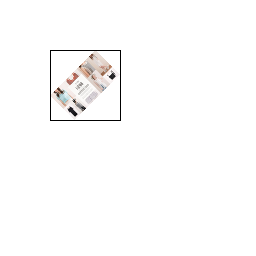

In [52]:
im = Image.new("RGBA", (256, 256))
p = Image.open("/workspace/CRAFT-pytorch/data/0a7c18c4c6c89108254a07b8a4cc1641.jpg").convert('RGBA')
p.thumbnail((64, 64))
p = p.rotate(45, expand=True)

im.paste(p, (50, 50))

# im.bbox
# im

draw = ImageDraw.Draw(im)
draw.rectangle(im.getbbox(), fill=None, outline=(0, 0, 0, 255))
# im.getbbox()
im